### So all other attempts at getting the Ising model to work seemingly are just completely noisy. 
Here, is a careful reimplementation of Schroder's algo. I expect no noise WITH NO AVERAGING at very high temps and very low temps. These should be good keystones to hit along the way

In [144]:
#imports 
import numpy as np
import random
import matplotlib.pyplot as plt

In [145]:
def initLattice(latticeSize: int, hot: bool) -> list[list[int]]:
    lattice = np.zeros((latticeSize, latticeSize))
    if hot:
        for i in range(latticeSize):
            for j in range(latticeSize):
                #pick a random spin
                spin = 0
                randomInt = random.randint(0,1)
                if(randomInt == 1):
                    spin = 1
                else:
                    spin = -1
                #set lattice site equal to the random spin    
                lattice[i][j] = spin
    else: #lattice is cold
        for i in range(latticeSize):
            for j in range(latticeSize):
                #set all lattice sites to spin up
                spin = 1
                lattice[i][j] = spin
    
    return lattice

In [248]:
initLattice(10,False)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [463]:
#It turns out some averaging is actually needed. This demonstrates over 1000 trials of a hot start 10x10 lattice, the expected magnetization is zero
#the expected value of magnetization i.e. the average mag at hot temp is 0, but each individual trial can be up to ~ +- 20
sumArr = []
for inter in range(1000):
    sum = 0
    lat = initLattice(10,True)
    for i in range(10):
        for j in range(10):
            sum += lat[i][j]
    sumArr.append(sum)

np.average(sumArr)


-0.622

In [146]:
# Calculate change in energy of lattice by flipping a single site (i,j)
def deltaU(i: int, j: int, lattice: list) -> float:
    '''
    This calulation requires considering neighboring sites (first term in Hamiltonian)
    Therefore, we will use periodic boundary conditions (torus)
    I would like to imlement the external field term so you can drive the system to specific states

    E1 = -spin(i,j)*sum(spin(neighbors)),     E2 = spin(i,j)*sum(spin(neighbors))
    Ediff = E2 - E1 = 2spin(i,j)*sum(neighbors) (if spin(i,j) is 1 (up))            <<<<< NO epsilon/J? unclear why, currently just implementing pseudocode exactly as written

    In the mean field approximation E_up = -4J*sum(spin(neighbors))/4) 

    i is vertical, j is horizontal, zero indexed
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    #now calculate the energy difference
    Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    return Ediff

In [147]:
def Metropolis(lattice, temp, iterations):
    m = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            m.append(abs(sum)) #NEW: try storing abs of mag

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]

    return m

In [593]:
size = 10
newLattice = initLattice(size,True)
#print(newLattice)
iterationNumber = 100*size*size
Metropolis(newLattice, 2.27, iterationNumber)
#print("\n")
#print(newLattice)


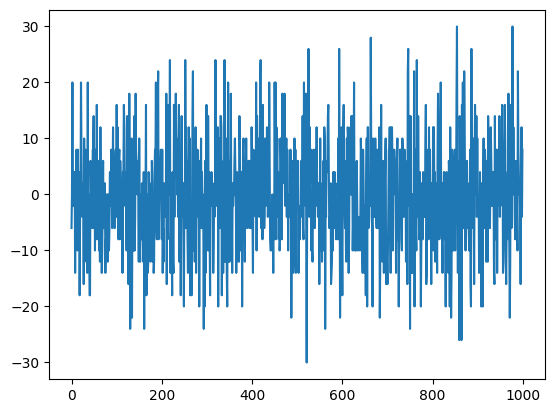

In [861]:
#time series data
sumArr = []
for inter in range(1000):
    sum = 0
    lat = initLattice(10,True)
    for i in range(10):
        for j in range(10):
            sum += lat[i][j]
    sumArr.append(sum)

plt.plot(np.arange(0,len(sumArr)), sumArr)


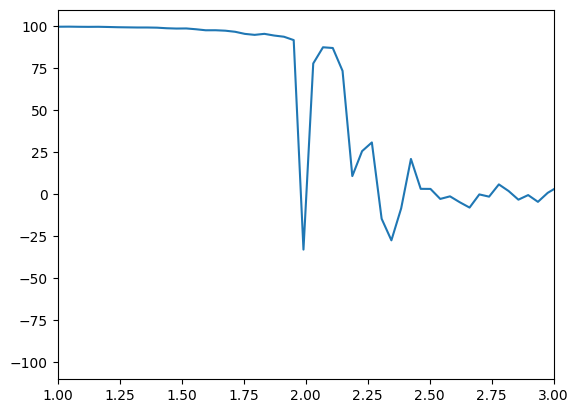

In [1187]:
#reuse averaging code from above with metropolis to make a curve
lat = initLattice(10,False)
avgMags = []
tempRange = np.linspace(0.1,4,100)
for temp in tempRange:
    mTimeSeries = Metropolis(lat, temp, 1000000)
    avg = np.average(mTimeSeries)
    avgMags.append(avg)
    
plt.xlim(1,3)
plt.ylim(-110,110)
plt.plot(tempRange, avgMags) 

Text(0, 0.5, 'Magnetization (100 is max)')

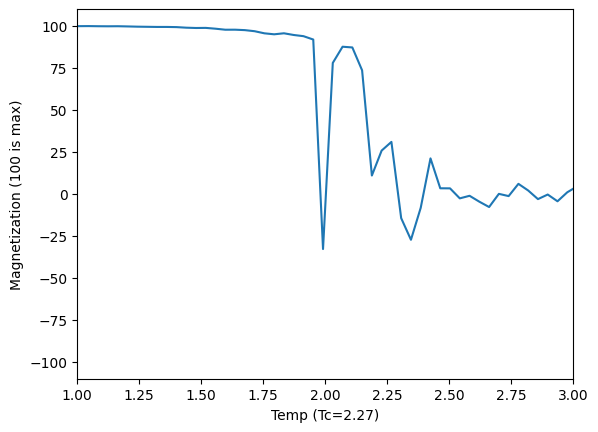

In [1194]:
plt.plot(tempRange, avgMags) 
plt.xlim(1,3)
plt.ylim(-110,110)
plt.xlabel("Temp (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")
#plt.xlim(0,100)

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Magnetization (100 is max)')

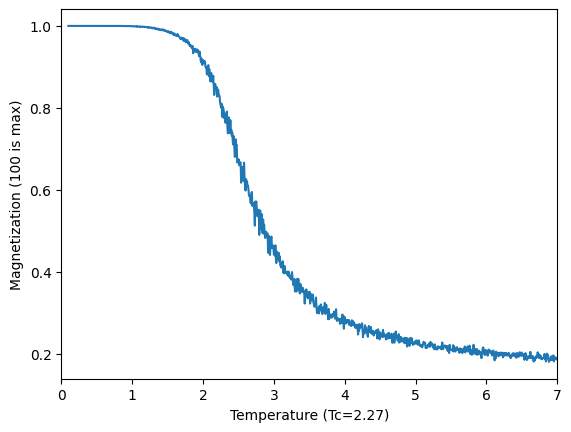

In [269]:
#reuse averaging code from above with metropolis to make a curve
size = 6
lat = initLattice(size,False)
avgMags = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))

    mTimeSeries = Metropolis(lat, temp, 100000)
    avg = np.average(mTimeSeries) / (np.power(size,2))
    avgMags.append(avg)
    



   


#plot output
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgMags) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

Text(0, 0.5, 'Magnetization (100 is max)')

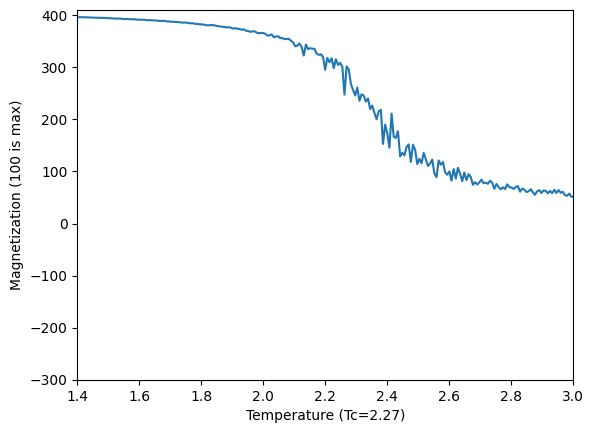

In [1744]:
plt.xlim(1.4,3)
plt.ylim(-300,20*20+10)
plt.plot(tempRange, avgMags) #IDEA: what if i now average over the average magnetization through the critical point so that its smooth? or at least a regression
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

Text(0, 0.5, 'Magnetization (100 is max)')

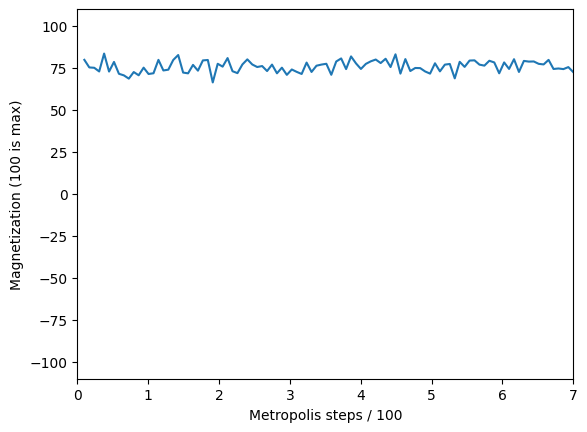

In [1728]:
#reuse averaging code from above with metropolis to make a curve
lat = initLattice(10,True)
avgMags = []
tempRange = np.linspace(0.1,7,100)
for temp in tempRange:
    mTimeSeries = Metropolis(lat, 2.27, 100000)
    avg = np.average(mTimeSeries)
    avgMags.append(avg)
    
plt.xlim(0,7)
plt.ylim(-110,110)
plt.plot(tempRange, avgMags) 
plt.xlabel("Metropolis steps / 100")
plt.ylabel("Magnetization (100 is max)")

some code to gernerate plots for multiple lattice sizes

In [1764]:
#reuse averaging code from above with metropolis to make a curve

avgMags = []

for size in np.arange(6,31,6):
    lat = initLattice(size,False)

    tempRange = np.linspace(0.1,7,1000)
    for temp in tempRange:
        percent = round((temp / 7) * 100, 1)
        print("T = %s      %s%%      s=%s" % (round(temp,3), percent, size))
        mTimeSeries = Metropolis(lat, temp, 1000000)
        avg = np.average(mTimeSeries)/ (np.power(size,2))
        avgMags.append(avg)

T = 0.1      1.4%      s=6
T = 0.107      1.5%      s=6
T = 0.114      1.6%      s=6
T = 0.121      1.7%      s=6
T = 0.128      1.8%      s=6
T = 0.135      1.9%      s=6
T = 0.141      2.0%      s=6
T = 0.148      2.1%      s=6
T = 0.155      2.2%      s=6
T = 0.162      2.3%      s=6
T = 0.169      2.4%      s=6
T = 0.176      2.5%      s=6
T = 0.183      2.6%      s=6
T = 0.19      2.7%      s=6
T = 0.197      2.8%      s=6
T = 0.204      2.9%      s=6
T = 0.211      3.0%      s=6
T = 0.217      3.1%      s=6
T = 0.224      3.2%      s=6
T = 0.231      3.3%      s=6
T = 0.238      3.4%      s=6
T = 0.245      3.5%      s=6
T = 0.252      3.6%      s=6
T = 0.259      3.7%      s=6
T = 0.266      3.8%      s=6
T = 0.273      3.9%      s=6
T = 0.28      4.0%      s=6
T = 0.286      4.1%      s=6
T = 0.293      4.2%      s=6
T = 0.3      4.3%      s=6
T = 0.307      4.4%      s=6
T = 0.314      4.5%      s=6
T = 0.321      4.6%      s=6
T = 0.328      4.7%      s=6
T = 0.335      4.8% 

In [1765]:
threeHourRun = avgMags

In [1780]:
L6 = threeHourRun[0:1000]
L12 = threeHourRun[1000:2000]
L18 = threeHourRun[2000:3000]
L24 = threeHourRun[3000:4000]
L30 = threeHourRun[4000:5000]

Text(0, 0.5, 'Average Magnetization')

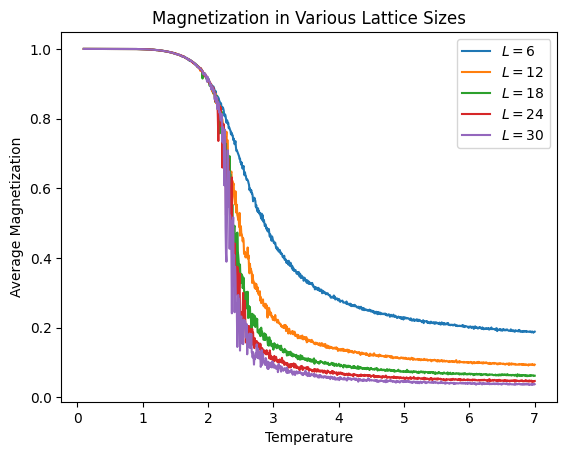

In [1784]:
plt.plot(tempRange, L6, label="$L=6$") 
plt.plot(tempRange, L12, label="$L=12$") 
plt.plot(tempRange, L18, label="$L=18$") 
plt.plot(tempRange, L24, label="$L=24$") 
plt.plot(tempRange, L30, label="$L=30$") 
plt.legend()
plt.title("Magnetization in Various Lattice Sizes")
plt.xlabel("Temperature")
plt.ylabel("Average Magnetization")
#THIS JUST FROM TAKING ABS. I should read binder more and implement Wolff for a cluster algorithm

In [1774]:
import json

with open('ThreeHourMagABS.txt', 'w') as filehandle:
    json.dump(threeHourRun, filehandle)

Following some Binder things.

In [1013]:
#define a weird cumulant and determine when the intersect to find critical temperature.
def m24(lattice, temp, iterations):
    m = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            m.append(abs(sum)) #NEW: try storing abs of mag

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]


    return (np.power(m,2), np.power(m,4))

In [1014]:
#SIZE = 12
avgm220 = []
avgm420 = []
size = 12
lat = initLattice(size,False)

tempRange = np.linspace(2.1,2.4,1000)
for temp in tempRange:
    percent = round(((temp-2.1) / (2.4-2.1)) * 100, 1)
    print("T = %s      %s%%      s=%s" % (round(temp,3), percent, size))
    m20 = m24(lat, temp, 100000) #lattice size 20 mags #500000
    m220 = m20[0] #m^2 for lattice size 20
    m420 = m20[1] #m^4 for lattice size 20
    
    #average m^2
    avg220 = np.average(m220)  # get rid of normalization  / (np.power(size,2))   SHOULD I ADD ERROR BARS HERE?
    avgm220.append(avg220) 

    #average m^4
    avg420 = np.average(m420)  # get rid of normalization/ (np.power(size,2))
    avgm420.append(avg420) 

T = 2.1      0.0%      s=12
T = 2.1      0.1%      s=12
T = 2.101      0.2%      s=12
T = 2.101      0.3%      s=12
T = 2.101      0.4%      s=12
T = 2.102      0.5%      s=12
T = 2.102      0.6%      s=12
T = 2.102      0.7%      s=12
T = 2.102      0.8%      s=12
T = 2.103      0.9%      s=12
T = 2.103      1.0%      s=12
T = 2.103      1.1%      s=12
T = 2.104      1.2%      s=12
T = 2.104      1.3%      s=12
T = 2.104      1.4%      s=12
T = 2.105      1.5%      s=12
T = 2.105      1.6%      s=12
T = 2.105      1.7%      s=12
T = 2.105      1.8%      s=12
T = 2.106      1.9%      s=12
T = 2.106      2.0%      s=12
T = 2.106      2.1%      s=12
T = 2.107      2.2%      s=12
T = 2.107      2.3%      s=12
T = 2.107      2.4%      s=12
T = 2.108      2.5%      s=12
T = 2.108      2.6%      s=12
T = 2.108      2.7%      s=12
T = 2.108      2.8%      s=12
T = 2.109      2.9%      s=12
T = 2.109      3.0%      s=12
T = 2.109      3.1%      s=12
T = 2.11      3.2%      s=12
T = 2.11      3

In [1015]:
#SIZE = 24
avgm210 = []
avgm410 = []
size = 24
lat = initLattice(size,False)

tempRange = np.linspace(2.1,2.4,1000)
for temp in tempRange:
    percent = round(((temp-2.1) / (2.4-2.1)) * 100, 1)
    print("T = %s      %s%%      s=%s" % (round(temp,3), percent, size))
    m10 = m24(lat, temp, 100000) #lattice size 20 mags
    m210 = m10[0] #m^2 for lattice size 20
    m410 = m10[1] #m^4 for lattice size 20
    
    #average m^2
    avg210 = np.average(m210)  # get rid of normalization  / (np.power(size,2)) / (np.power(size,2))
    avgm210.append(avg210) 

    #average m^4
    avg410 = np.average(m410)  # get rid of normalization  / (np.power(size,2))/ (np.power(size,2))
    avgm410.append(avg410)

T = 2.1      0.0%      s=24
T = 2.1      0.1%      s=24
T = 2.101      0.2%      s=24
T = 2.101      0.3%      s=24
T = 2.101      0.4%      s=24
T = 2.102      0.5%      s=24
T = 2.102      0.6%      s=24
T = 2.102      0.7%      s=24
T = 2.102      0.8%      s=24
T = 2.103      0.9%      s=24
T = 2.103      1.0%      s=24
T = 2.103      1.1%      s=24
T = 2.104      1.2%      s=24
T = 2.104      1.3%      s=24
T = 2.104      1.4%      s=24
T = 2.105      1.5%      s=24
T = 2.105      1.6%      s=24
T = 2.105      1.7%      s=24
T = 2.105      1.8%      s=24
T = 2.106      1.9%      s=24
T = 2.106      2.0%      s=24
T = 2.106      2.1%      s=24
T = 2.107      2.2%      s=24
T = 2.107      2.3%      s=24
T = 2.107      2.4%      s=24
T = 2.108      2.5%      s=24
T = 2.108      2.6%      s=24
T = 2.108      2.7%      s=24
T = 2.108      2.8%      s=24
T = 2.109      2.9%      s=24
T = 2.109      3.0%      s=24
T = 2.109      3.1%      s=24
T = 2.11      3.2%      s=24
T = 2.11      3

In [1022]:
#SIZE = 18
avgm218 = []
avgm418 = []
size = 18
lat = initLattice(size,False)

tempRange = np.linspace(2.1,2.4,1000)
for temp in tempRange:
    percent = round(((temp-2.1) / (2.4-2.1)) * 100, 1)
    print("T = %s      %s%%      s=%s" % (round(temp,3), percent, size))
    m18 = m24(lat, temp, 100000) #lattice size 20 mags #500000
    m218 = m18[0] #m^2 for lattice size 20
    m418 = m18[1] #m^4 for lattice size 20
    
    #average m^2
    avg218 = np.average(m218)  # get rid of normalization  / (np.power(size,2))   SHOULD I ADD ERROR BARS HERE?
    avgm218.append(avg218) 

    #average m^4
    avg418 = np.average(m418)  # get rid of normalization/ (np.power(size,2))
    avgm418.append(avg418) 

T = 2.1      0.0%      s=18
T = 2.1      0.1%      s=18
T = 2.101      0.2%      s=18
T = 2.101      0.3%      s=18
T = 2.101      0.4%      s=18
T = 2.102      0.5%      s=18
T = 2.102      0.6%      s=18
T = 2.102      0.7%      s=18
T = 2.102      0.8%      s=18
T = 2.103      0.9%      s=18
T = 2.103      1.0%      s=18
T = 2.103      1.1%      s=18
T = 2.104      1.2%      s=18
T = 2.104      1.3%      s=18
T = 2.104      1.4%      s=18
T = 2.105      1.5%      s=18
T = 2.105      1.6%      s=18
T = 2.105      1.7%      s=18
T = 2.105      1.8%      s=18
T = 2.106      1.9%      s=18
T = 2.106      2.0%      s=18
T = 2.106      2.1%      s=18
T = 2.107      2.2%      s=18
T = 2.107      2.3%      s=18
T = 2.107      2.4%      s=18
T = 2.108      2.5%      s=18
T = 2.108      2.6%      s=18
T = 2.108      2.7%      s=18
T = 2.108      2.8%      s=18
T = 2.109      2.9%      s=18
T = 2.109      3.0%      s=18
T = 2.109      3.1%      s=18
T = 2.11      3.2%      s=18
T = 2.11      3

In [1017]:
div10 = []
for i in range(len(avgm210)):
    div10.append(1 - (avgm410[i]) / (3*np.power(avgm210[i],2)) )

In [1018]:
div20 = []
for i in range(len(avgm220)):
    div20.append(1 - (avgm420[i]) / (3*np.power(avgm220[i],2)) )

In [1023]:
div18 = []
for i in range(len(avgm218)):
    div18.append(1 - (avgm418[i]) / (3*np.power(avgm218[i],2)) )

### Make susceptibility plots once this is done NO MATTER WHAT

2.26310940475424

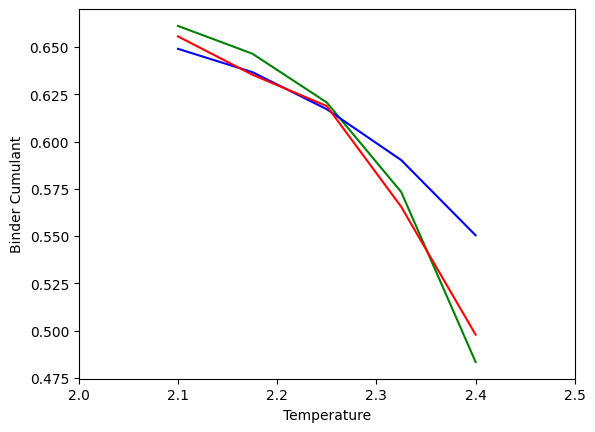

In [1030]:
from scipy import interpolate
from scipy import optimize
averagingWindow = 200 # 200

avg10 = []
for i in range(len(div10)+1):
    if(i % averagingWindow == 0 and i != 0):
        avg10.append(np.average(div10[i-averagingWindow:i]))

avg20 = []
for i in range(len(div20)+1):
    if(i % averagingWindow == 0 and i != 0):
        avg20.append(np.average(div20[i-averagingWindow:i]))

avg18 = []
for i in range(len(div18)+1):
    if(i % averagingWindow == 0 and i != 0):
        avg18.append(np.average(div18[i-averagingWindow:i]))


xData = np.linspace(2.1,2.4,int((1000/averagingWindow)))

# print(len(avg10))
# print(int((1000/averagingWindow)))
#plt.plot(tempRange, div10)

f10 = interpolate.interp1d(xData, avg10)
f20 = interpolate.interp1d(xData, avg20)
f18 = interpolate.interp1d(xData, avg18)
def fRoot(x):
    return f20(x)-f10(x)
plt.plot(xData, f10(xData), color="green")
#plt.scatter(xData, avg10, color="red", s=5)
#plt.plot(tempRange, div20)
plt.plot(xData, f20(xData), color="blue")
plt.plot(xData, f18(xData), color="red")
#plt.plot(xData, fRoot(xData))
#plt.scatter(xData, avg20, s=5, color="blue")
plt.ylabel("Binder Cumulant")
plt.xlabel("Temperature")
plt.xlim(2,2.5)


optimize.brentq(fRoot, 2.1, 2.4)

Mathematica gives a solution of $T_c = 2.26672 \approx 2.27$. It is time to figure out error bars. An idea for error bars: calculate the standard deviation (first moment) of the data we are averaging moverand then just plot 2 sigma error bars.

$\sigma = \sqrt{ \frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2}$ where $\mu \equiv \frac{1}{N} \sum_{i=1}^N x_i$ and $N$ is the size of the population.

In [268]:
import json

# InterpolatedBinderL20 = []
# for i in xData:
#     InterpolatedBinderL20.append(float(f20(i)))
list(xData)
with open('xData', 'w') as filehandle:
    json.dump(list(xData), filehandle)

In [10]:
def MetCor(lattice, temp, iterations):
    corArr = []
    prodArr = []
    s1Arr = []
    s2Arr = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            i1 = 1
            j1 = 1
            i2 = size-1
            j2 = size-1

            #measure and store product of lattice sites
            prod = lattice[i1][j1] * lattice[i2][j2]
            prodArr.append(prod) 

            #measure and store each spin state
            s1Arr.append(lattice[i1][j1])
            s2Arr.append(lattice[i2][j2])

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]

    #now calculate correlation and store it
    avgProd = np.average(prodArr)
    avgS1 = np.average(s1Arr)
    avgS2 = np.average(s2Arr)

    cor = avgProd - (avgS1)*(avgS2)

    return cor

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Correlation')

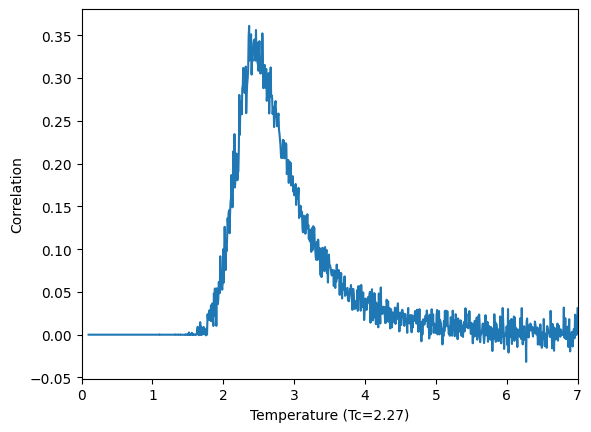

In [122]:
#reuse averaging code from above with metropolis to make a curve
size = 6
lat = initLattice(size,False)
avgCor = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))
    averaging = []
    for i in range(100):
        corTimeSeries = MetCor(lat, temp, 10000)
        averaging.append(corTimeSeries)
    avgCor.append(np.average(averaging))
    
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgCor) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Correlation")

In [118]:
for i in range(10):
    corTimeSeries = MetCor(lat, 100, 10000)
    averaging.append(corTimeSeries)
avgCor = np.average(averaging)

print(avgCor)


-0.01793762427931951


In [123]:
#do cumulation calclation next

Susceptibility Calc: $\chi = N\beta \left( \langle m^2 \rangle - \langle m \rangle^2 \right)$ where $\beta \equiv \frac{1}{kT}$ and $N$ is the number of sites.

In [159]:
def MetSus(lattice, temp, iterations):
    m = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            m.append(abs(sum)) #NEW: try storing abs of mag

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]

    return (m, np.power(m,2))

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Magnetization (100 is max)')

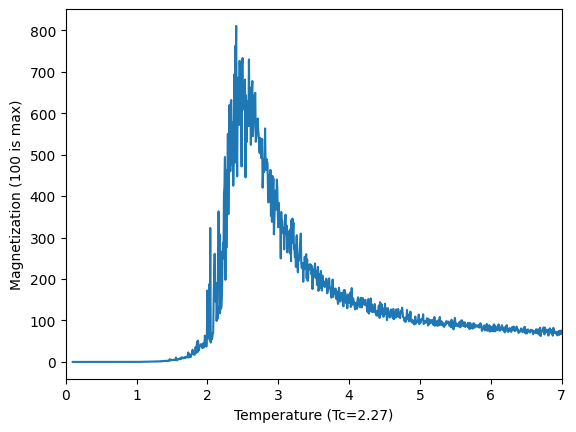

In [168]:
#reuse averaging code from above with metropolis to make a curve
size = 10 
lat = initLattice(size,False)
avgSus10 = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))
    TimeSeries = MetSus(lat, temp, 100000)
    avgM = np.average(TimeSeries[0])
    avgMSquared = np.power(avgM,2)
    avgSquaredM = np.average(TimeSeries[1])
    sus = avgSquaredM - avgMSquared
    avgSus10.append(sus)
    
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgSus10) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Magnetization (100 is max)')

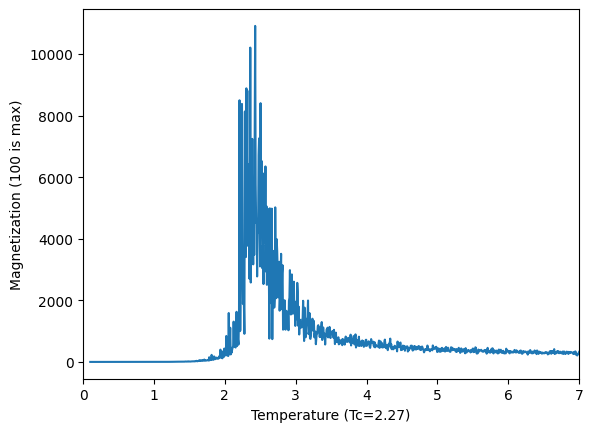

In [167]:
#reuse averaging code from above with metropolis to make a curve
size = 20 
lat = initLattice(size,False)
avgSus20 = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))
    TimeSeries = MetSus(lat, temp, 100000)
    avgM = np.average(TimeSeries[0])
    avgMSquared = np.power(avgM,2)
    avgSquaredM = np.average(TimeSeries[1])
    sus = avgSquaredM - avgMSquared
    avgSus20.append(sus)
    
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgSus20) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/var/folders/tf/m_q5jhc978j5bnsvc9p4163h0000gn/T/ipykernel_19100/1415078815.py:8: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi$")


Text(0, 0.5, '$\\chi$')

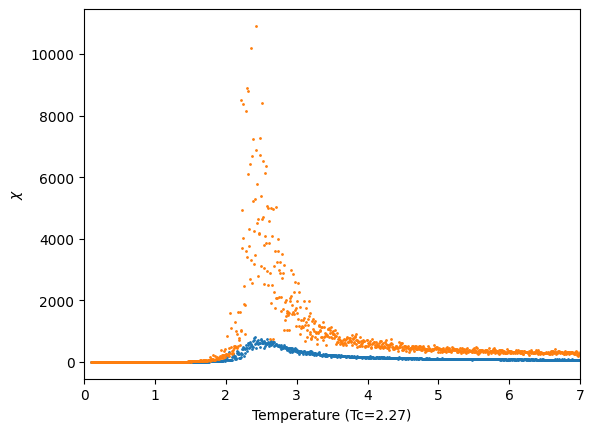

In [175]:
import copy

plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.scatter(tempRange, avgSus10, s=1) 
plt.scatter(tempRange, avgSus20, s=1)
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("$\chi$")

Standard deviation calculations

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Magnetization (100 is max)')

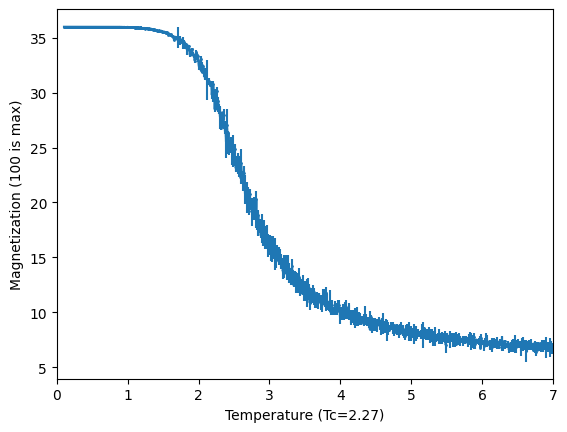

In [288]:
#reuse averaging code from above with metropolis to make a curve
size = 6
lat = initLattice(size,False)
avgMags = []
stdArr = []
tempRange = np.linspace(0.1,7,1000) # 1000
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))

    mTimeSeries = Metropolis(lat, temp, 100000) #100000

    #calculate standard deviation now that we have 
    N = len(mTimeSeries)
    mu = np.average(mTimeSeries)
    
    for i in range(len(mTimeSeries)):
        param = np.power(mTimeSeries[i] - mu, 2)
    
    std = np.sqrt((param) / (N))
    stdArr.append(2*std)

    #append mag data
    avgMags.append(mu)
    



   

print(stdArr)
#plot output
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.scatter(tempRange, avgMags, s=1) 
plt.errorbar(tempRange, avgMags, stdArr)
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

Text(0, 0.5, 'Magnetization (100 is max)')

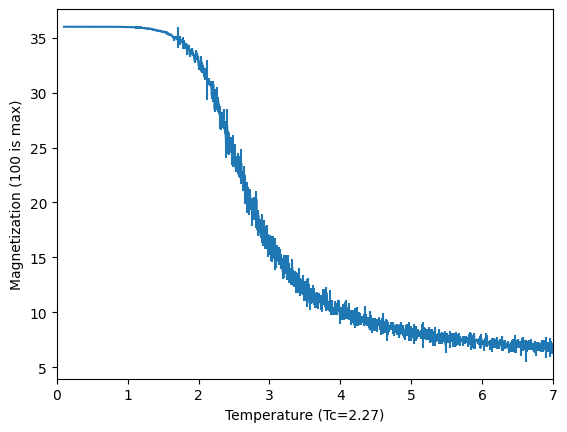

In [289]:
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
#plt.scatter(tempRange, avgMags, s=1) 
plt.errorbar(tempRange, avgMags, stdArr)
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

We finally do autocorrelation calculations

Unnormalized Correlation Function: $\hat{C}(t) = \hat{C}_{ij} = \langle f_0f_t \rangle - \hat{f}^2$ where $\hat{f} \equiv \text{average of } f$ \
Normalized Correlation Function: $\rho \equiv \frac{C(t)}{C(0)}$  \
Exponential Correlation: $\hat{C}(t) \sim \exp \left( -\frac{t}{\tau_{\exp}} \right)$ as $t \to \infty$ where $\tau_{\exp}$ is the (exponential) autocorrelation time

0.0%
0.1%
0.2%
0.3%
0.4%
0.5%
0.6%
0.7%
0.8%
0.9%
1.0%
1.1%
1.2%
1.3%
1.4%
1.5%
1.6%
1.7%
1.8%
1.9%
2.0%
2.1%
2.2%
2.3%
2.4%
2.5%
2.6%
2.7%
2.8%
2.9%
3.0%
3.1%
3.2%
3.3%
3.4%
3.5%
3.6%
3.7%
3.8%
3.9%
4.0%
4.1%
4.2%
4.3%
4.4%
4.5%
4.6%
4.7%
4.8%
4.9%
5.0%
5.1%
5.2%
5.3%
5.4%
5.5%
5.6%
5.7%
5.8%
5.9%
6.0%
6.1%
6.2%
6.3%
6.4%
6.5%
6.6%
6.7%
6.8%
6.9%
7.0%
7.1%
7.2%
7.3%
7.4%
7.5%
7.6%
7.7%
7.8%
7.9%
8.0%
8.1%
8.2%
8.3%
8.4%
8.5%
8.6%
8.7%
8.8%
8.9%
9.0%
9.1%
9.2%
9.3%
9.4%
9.5%
9.6%
9.7%
9.8%
9.9%
10.0%
10.1%
10.2%
10.3%
10.4%
10.5%
10.6%
10.7%
10.8%
10.9%
11.0%
11.1%
11.2%
11.3%
11.4%
11.5%
11.6%
11.7%
11.8%
11.9%
12.0%
12.1%
12.2%
12.3%
12.4%
12.5%
12.6%
12.7%
12.8%
12.9%
13.0%
13.1%
13.2%
13.3%
13.4%
13.5%
13.6%
13.7%
13.8%
13.9%
14.0%
14.1%
14.2%
14.3%
14.4%
14.5%
14.6%
14.7%
14.8%
14.9%
15.0%
15.1%
15.2%
15.3%
15.4%
15.5%
15.6%
15.7%
15.8%
15.9%
16.0%
16.1%
16.2%
16.3%
16.4%
16.5%
16.6%
16.7%
16.8%
16.9%
17.0%
17.1%
17.2%
17.3%
17.4%
17.5%
17.6%
17.7%
17.8%
17.9%
18.0%
18.1%
18.2%
18

Text(0, 0.5, 'Magnetization ')

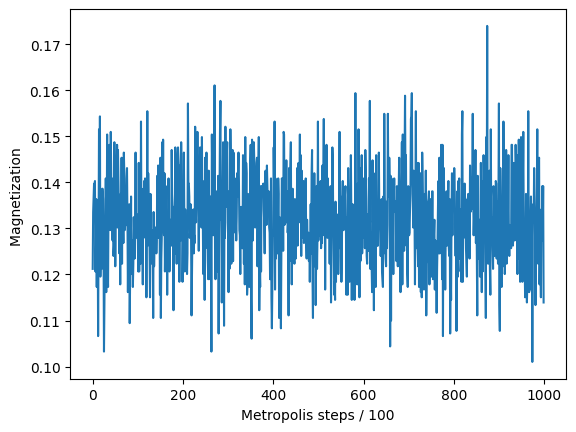

In [335]:
#reuse averaging code from above with metropolis to make a curve
size = 6
lat = initLattice(size,False)
avgMags = []
metSteps = np.arange(1000)
for step in metSteps:
    percent = round((step / metSteps.size) * 100, 1)
    print("%s%%" % percent)

    mTimeSeries = Metropolis(lat, 10000, 10000)
    avg = np.average(mTimeSeries) / (np.power(size,2))
    avgMags.append(avg)
    


#plot output
#plt.xlim(0,7)
#plt.ylim(-110,size*size + 10)
plt.plot(metSteps, avgMags) 
plt.xlabel("Metropolis steps / 100")
plt.ylabel("Magnetization ")

In [416]:
def autoCor(startTime: int, stopTime: int, timeSeriesData: list) -> float: #we are in metropolis-steps-time
    f = np.average(timeSeriesData)
    prod = timeSeriesData[startTime] * timeSeriesData[stopTime]
    #autoRes = ((timeSeriesData[startTime] + timeSeriesData[stopTime]) / (2)) - np.power(f,2)
    autoRes = prod - np.power(f,2)
    return autoRes

In [1083]:
def autoCorFIX(lagTime: int, timeSeriesData: list) -> float:
    '''
    Calculate the autocorrelation of some time series data 
    '''
    mu = np.average(timeSeriesData)
    prodArr = []
    #now average the product of function * laggedFunction over the range until N-t
    N = len(timeSeriesData)
    for i in range(N-lagTime):
        product = timeSeriesData[i] * timeSeriesData[i+lagTime]
        prodArr.append(product)
        #print(i)
        #print(i+lagTime)
        #print()
    
    #average the product
    avgProd = np.average(prodArr)

    #calculate autoCor
    ac = avgProd - np.power(mu,2)
    return ac


issue is that if our list is 10000 long but the sin function only goes 0 to 2pi the lag time index doesn't correspond to "real" time-series monte carlo time

## INTERESTING EFFECT! The autocorellation magnitude dies off for the L=2pi zero (correctionL it always goes to zero smoothyl at end of domain. only at infinity would it be cos)

-0.12725074543027906


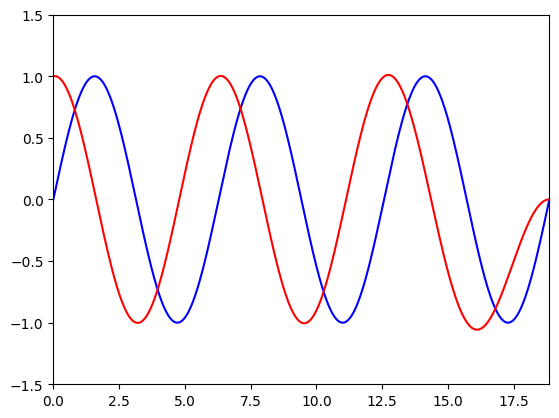

In [1124]:
xRes = 1000
domain = 6
sinX = np.linspace(0,domain*np.pi,xRes) #np.linspace(0,2*np.pi,xRes)
sinY = [np.sin(x) for x in sinX]

print(autoCorFIX(100,sinY))

lagArr = np.arange(0,xRes)
zeroLag = autoCorFIX(0,sinY)
autoPlot = [autoCorFIX(t,sinY)/zeroLag for t in lagArr]


plt.xlim(0,domain*np.pi)
plt.ylim(-1.5,1.5)
plt.plot(sinX,sinY,color="blue")
plt.plot(sinX, autoPlot,color="red")

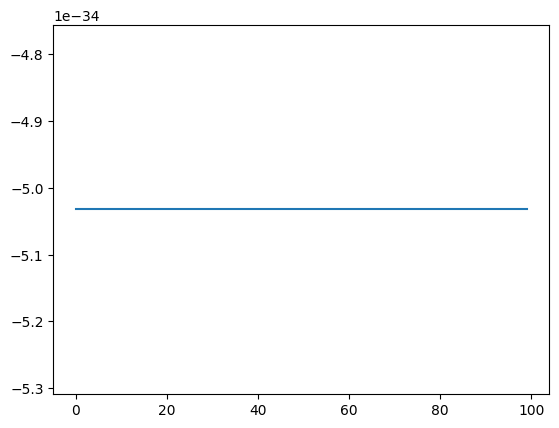

In [417]:
sinY = [np.sin(x) for x in np.linspace(0,2*np.pi,100)]
sinX = np.linspace(0,2*np.pi,100)
#plt.plot(sinX, sinY)

# #plot output
# #plt.xlim(0,7)
# plt.ylim(-1, 1)
# plt.plot(metSteps, avgMags) 
# plt.xlabel("Metropolis steps / 100")
# plt.ylabel("Magnetization ")

xx = np.arange(100)
#normAutoCor = [autoCor(0,step,avgMags)/autoCor(0,0,avgMags) for step in xx]
#plt.plot(xx, normAutoCor) #normalized autoCor plot

normAutoCor = [autoCor(0,step,sinY) for step in xx]
plt.plot(xx, normAutoCor) #normalized autoCor plot

this autocorellation is clearly wrong? BIG work tomorrow :/ got nothing done today :(

## Is my minimum t actually 100 because in metropolis I only take data every 100 steps?

work on making correlation as a function radius and beta this weekend

For fun, lets try the fourier transform of the lattice

In [515]:
#idea: try doing FFT of 1d lattice. Interpolate each point (1/-1) on the lattice to box functions of unit width. Then FFT this function

def initOneDimensionalLattice(latticeSize: int, hot: bool) -> list[int]:
    lattice = np.zeros(latticeSize)
    if hot:
        for i in range(latticeSize):
            #pick a random spin
            spin = 0
            randomInt = random.randint(0,1)
            if(randomInt == 1):
                spin = 1
            else:
                spin = -1
            #set lattice site equal to the random spin    
            lattice[i] = spin
    else: #lattice is cold
        for i in range(latticeSize):
            #set all lattice sites to spin up
            spin = 1
            lattice[i] = spin
    
    return lattice

In [589]:
def latticeToFunction(lattice: list) -> list:
    #Take in a lattice and interpolate to a function of box functions

    roughArrX = []
    roughArrY = [] #array to store a rough outline of the function to interpolate

    for latticeSite in np.arange(len(lattice)):
        #add x coords
        latticeSiteLeft = latticeSite
        latticeSiteMid = latticeSite + 0.5
        latticeSiteRight = latticeSite + 1
        latticeSiteArrX = [latticeSiteLeft, latticeSiteMid, latticeSiteRight]
        roughArrX.extend(latticeSiteArrX)

        #add y coords
        latticeSiteArrY = [lattice[latticeSite]]
        roughArrY.extend(latticeSiteArrY * len(latticeSiteArrX))


    return (roughArrX, roughArrY)

In [585]:
import math

In [790]:
def latticeToFunctionTWO(lattice: list, x: float) -> list:
    latSize = len(lattice)
    if(x == 0):
        return 0
    index = math.floor(x) #convert float to int to get index
    if(index >= (latSize-1) or index < 0):
        return 0
    else:
        return lattice[index]


In [618]:
oneTest = initOneDimensionalLattice(6, True)
oneTest = initOneDimensionalLattice(6, True)
xx = latticeToFunction(oneTest)[0]
yy = latticeToFunction(oneTest)[1]
oneTest

array([-1.,  1., -1.,  1., -1., -1.])

In [835]:
from scipy import fft

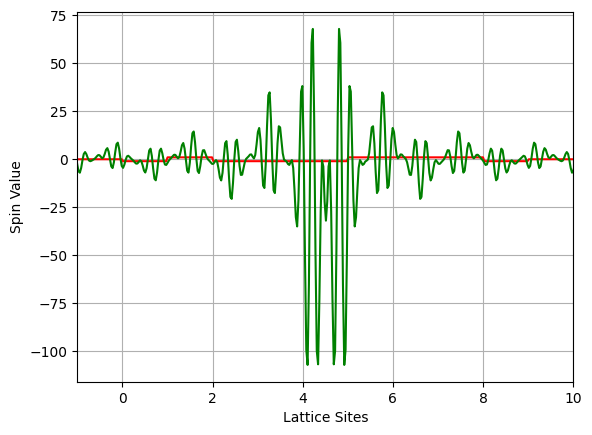

In [1011]:
latSize = 10

oneTest = initOneDimensionalLattice(latSize, True)
xx = latticeToFunction(oneTest)[0]
yy = latticeToFunction(oneTest)[1]

xxx = np.linspace(-10,latSize-1+10,1000)
#xxxx = np.linspace(-50,50,10000)
ff = [latticeToFunctionTWO(oneTest, x) for x in xxx]

yShift = np.fft.fftshift(ff)
fftyShift = np.fft.fft(yShift)
ffty = np.fft.fftshift(fftyShift)

#print(fft.fftfreq(len(ff)))
#interpolate
#ff = interpolate.interp1d(xx,yy,"zero")
#temp = fft.fft(ff)

#plt.scatter(xx,yy,color="blue")
plt.plot(xxx,ff,color="red")
plt.xlim(-1,10)
#plt.ylim(-10,10)
plt.plot(xxx,ffty,color="green")
plt.xlabel("Lattice Sites")
plt.ylabel("Spin Value")
plt.grid()

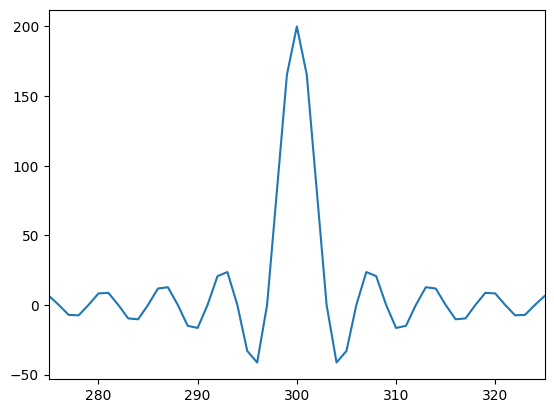

In [879]:
x = np.arange(-3, 3, 0.01)
y = np.zeros(len(x))
y[200:400] = 1
yShift = np.fft.fftshift(y)
fftyShift = np.fft.fft(yShift)
ffty = np.fft.fftshift(fftyShift)

plt.xlim(275, 325)
plt.plot(ffty)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


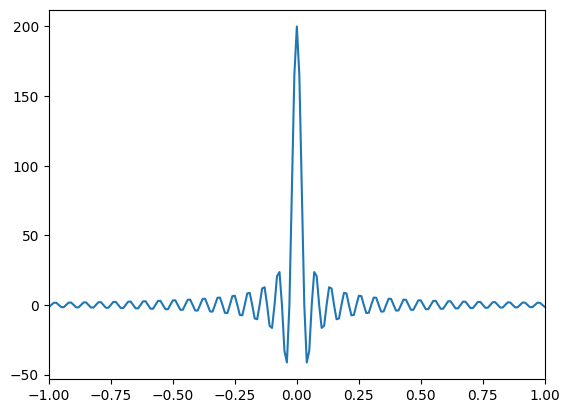

In [888]:
x = np.arange(-3, 3, 0.01)
y = np.zeros(len(x))
y[200:400] = 1

shi = fft.fftshift(y)
fftYY = fft.fft(shi)
fftShift = fft.fftshift(fftYY)

plt.xlim(-1,1)
#plt.plot(x,y)
plt.plot(x,fftShift)

In [952]:
critOutRaw = [2.1945810203769187, 2.3015383041603044, 2.378108660570429, 2.3414047132298235, 2.1572486530473127, 2.2323642673741935, 2.2573848734712456, 2.371857837282413, 2.290419638629001, 2.3143660729864024, 2.28722881444044, 2.256259931091214, 2.364606286027022, 0, 2.278842672998377, 2.3416113887168204, 2.271302154710069, 0, 2.3356738557923946, 2.324494759237984, 2.3300647488577497, 2.1569717040156986, 2.310345108157943, 2.2277025318965133, 2.1366504517060925, 2.2763748905645, 2.392374691128455, 0, 2.2838007734825436, 2.333274732465915, 0, 0, 2.339614993415079, 2.3425660772969294, 2.3663905311151328, 2.343600204840446, 2.305759627091808, 0, 2.3381611263611184, 2.340322793675882]

In [953]:
critOut = []
for out in critOutRaw:
    if out != 0:
        critOut.append(out)

In [959]:
print(np.average(critOut))
np.std(critOut)

2.2977432026533577


0.06388355627628353

So the critical temperature is $T_c = 2.298 \pm 0.064$ which is $T_c^- = 2.234$ andd $T_c^+ = 2.362$